# Lab8: In lab exercise
## st121411

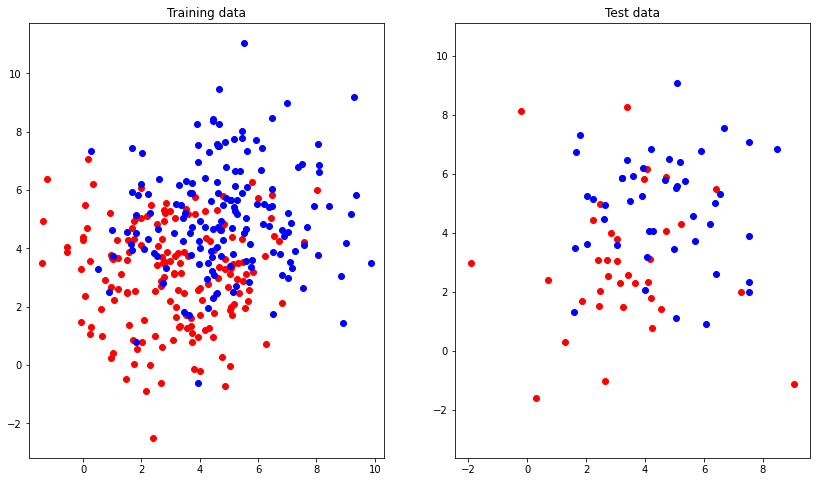

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(mu1, Sigma1, mu2, Sigma2):
    X1 = np.random.multivariate_normal(mu1, Sigma, 200)
    y1 = -np.ones((200,1))
    X2 = np.random.multivariate_normal(mu2, Sigma, 200)
    y2 = np.ones((200,1))
    X = np.concatenate((X1, X2), 0)
    y = np.concatenate((y1, y2), 0)
    idx = np.arange(0, 400)
    np.random.shuffle(idx)
    train_idx = idx[0:320]
    test_idx = idx[320:]
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx,:]
    y_test = y[test_idx,:]
    return X_train, X_test, y_train, y_test

mu1 = [3, 3]
Sigma = [[4, 0], [0, 4]]
mu2 = [5, 5]
X_train, X_test, y_train, y_test = generate_data(mu1, Sigma, mu2, Sigma)

def plot_data(X, y, title):
    X_0 = X[(y==-1).flat]
    X_1 = X[(y==1).flat]
    plt.plot(X_0[:,0], X_0[:,1], 'ro')
    plt.plot(X_1[:,0], X_1[:,1], 'bo')
    plt.title(title)
    plt.axis('equal')
    
plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')

In [2]:
import cvxopt

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))

In [3]:
C = 1000.1

m = X_train.shape[0];
n = X_train.shape[1];

def linear_kernel(X):
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = X[i,:] @ X[j,:].T
    return K;

K = linear_kernel(X_train);

Q = np.multiply(y_train * y_train.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);
b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
E = y_train.T;
d = np.zeros(1);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);

#print(alpha_star)

Q rank: 2
     pcost       dcost       gap    pres   dres
 0: -7.5076e+04 -2.3366e+08  5e+08  6e-01  1e-10
 1: -6.1277e+04 -5.3248e+07  5e+07  2e-13  7e-11
 2: -1.0305e+05 -7.7184e+05  7e+05  4e-12  6e-11
 3: -1.2095e+05 -2.2760e+05  1e+05  6e-12  7e-11
 4: -1.5424e+05 -2.0466e+05  5e+04  3e-12  1e-10
 5: -1.6662e+05 -1.9085e+05  2e+04  7e-12  1e-10
 6: -1.7240e+05 -1.8368e+05  1e+04  6e-12  1e-10
 7: -1.7554e+05 -1.7988e+05  4e+03  3e-12  1e-10
 8: -1.7705e+05 -1.7803e+05  1e+03  7e-12  1e-10
 9: -1.7733e+05 -1.7768e+05  3e+02  3e-13  1e-10
10: -1.7748e+05 -1.7751e+05  2e+01  8e-13  1e-10
11: -1.7749e+05 -1.7749e+05  6e-01  3e-13  1e-10
12: -1.7749e+05 -1.7749e+05  6e-03  1e-12  1e-10
Optimal solution found.


Let's get $\mathbf{w}$ and $b$ and plot:

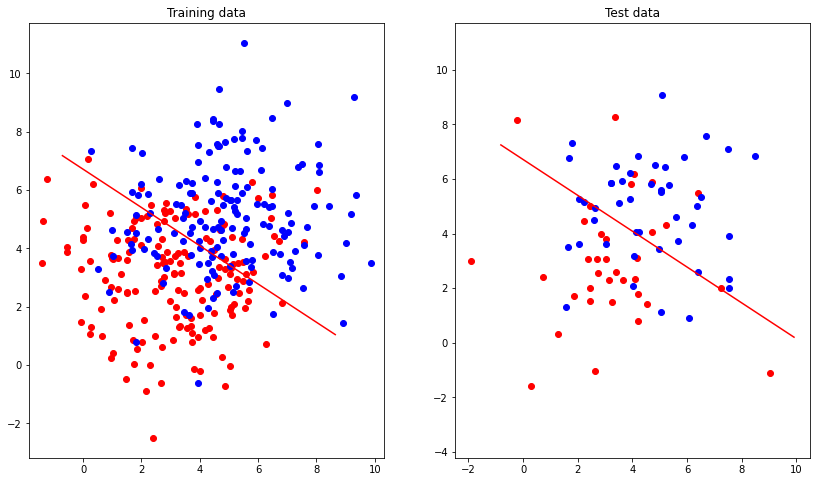

In [4]:
def get_wb(X, y, alpha):
    n = X.shape[1]
    # Find the support vectors
    S = alpha > 1e-6
    XS = X[S,:]
    yS = y[S]
    alphaS = alpha[S]
    alphaSyS = np.tile(np.multiply(yS.T, alphaS).T, n)
    w = sum(np.multiply(alphaSyS, XS)).T
    # Find b
    KS = K[S,:][:,S]
    NS = yS.shape[0]
    b = (np.sum(yS) - np.sum(np.multiply(alphaS,yS.T)*KS))/NS
    # Normalize w,b
    scalef = np.linalg.norm(w)
    w = w / scalef
    b = b / scalef
    return w,b

w,b = get_wb(X_train, y_train, alpha_star)

def boundary_points(X, w, b):
    v_orthogonal = np.array([[w[0]],[w[1]]])
    v_ortho_length = np.sqrt(v_orthogonal.T @ v_orthogonal)
    dist_ortho = b / v_ortho_length
    v_orthogonal = v_orthogonal / v_ortho_length
    v_parallel = np.array([[-v_orthogonal[1,0]],[v_orthogonal[0,0]]])
    projections = X @ v_parallel
    proj_1 = min(projections)
    proj_2 = max(projections)
    point_1 = proj_1 * v_parallel - dist_ortho * v_orthogonal
    point_2 = proj_2 * v_parallel - dist_ortho * v_orthogonal
    return point_1, point_2

def plot_w(X, w, b):
    p1, p2 = boundary_points(X, w, b)
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')

plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
plot_w(X_train, w, b)
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')
plot_w(X_test, w, b)


NOTE TO MYSELF:
FIND THE FUNCTION TO PREDICT WITH A KERNEL,
FIND THE FUNCTION TO GET THE ACCURACY WITH A KERNEL

In [5]:
def predict(w,b,X):
    y_pred = X@w+b
    y_pred[y_pred >= 0] = 1
    y_pred[y_pred < 0] = -1
    return y_pred

def accuracy(y_t,y_pred):
    return (np.sum(y_t.reshape(-1)==y_pred)/y_t.size)

y_pred = predict(w,b,X_test)
print(accuracy(y_test,y_pred))

0.725


In [6]:
acc = []

K = linear_kernel(X_train);

Q = np.multiply(y_train * y_train.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);

C_range = np.logspace(-5,5,20)
for C in C_range:
    b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
    E = y_train.T;
    d = np.zeros(1);
    alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
    w,b = get_wb(X_train, y_train, alpha_star)
    print(w,b)
    y_pred = predict(w,b,X_test)
    acc.append(accuracy(y_test,y_pred))
    
acc = np.array(acc)
print(acc)

Q rank: 2
     pcost       dcost       gap    pres   dres
 0: -1.0619e+02 -3.8668e-02  2e+03  5e+01  1e-13
 1: -1.1434e+00 -3.8520e-02  3e+01  5e-01  2e-13
 2: -8.2364e-02 -2.8043e-02  1e+00  2e-02  7e-15
 3: -5.8020e-03 -8.5143e-03  7e-02  1e-03  1e-15
 4: -2.3102e-03 -7.4314e-03  5e-03  2e-19  8e-16
 5: -2.6631e-03 -4.3293e-03  2e-03  5e-20  5e-16
 6: -2.9863e-03 -3.5025e-03  5e-04  5e-20  4e-16
 7: -3.0899e-03 -3.1484e-03  6e-05  4e-20  4e-16
 8: -3.0911e-03 -3.0978e-03  7e-06  7e-20  4e-16
 9: -3.0912e-03 -3.0976e-03  6e-06  7e-20  6e-16
10: -3.0914e-03 -3.0944e-03  3e-06  3e-20  7e-16
11: -3.0920e-03 -3.0936e-03  2e-06  4e-20  4e-16
12: -3.0924e-03 -3.0931e-03  7e-07  4e-20  3e-16
13: -3.0926e-03 -3.0928e-03  2e-07  4e-20  3e-16
14: -3.0927e-03 -3.0927e-03  8e-09  4e-20  4e-16
Optimal solution found.
[0.66671724 0.74531075] -5.823038140806274
     pcost       dcost       gap    pres   dres
 0: -1.0619e+02 -5.6302e-02  2e+03  5e+01  1e-13
 1: -1.1454e+00 -5.6160e-02  3e+01  5e-01  

In [7]:
C_best = C_range[np.argmax(acc)]
print("Best value for C = ", C_best)

Best value for C =  0.0012742749857031334


In [8]:
import random
import matplotlib.patches as mpatches

# Convert lists into matrix
def mat(lists):
    return np.matrix(lists)

def selectJrandom(i,m):
    j=i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlphaJ(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

def simplifiedSMO(dataX, classY, C, tol, max_passes):
    X = mat(dataX)
    Y = mat(classY).T
    m,n = np.shape(X)
    # Initialize b: threshold for solution
    b = 0;      
    # Initialize alphas: lagrange multipliers for solution
    alphas = mat(np.zeros((m,1)))
    passes = 0
    while (passes < max_passes):
        num_changed_alphas = 0
        for i in range(m):
            # Calculate Ei = f(xi) - yi
            fXi = float(np.multiply(alphas,Y).T*(X*X[i,:].T)) + b
            Ei = fXi - float(Y[i])
            if ((Y[i]*Ei < -tol) and (alphas[i] < C)) or ((Y[i]*Ei > tol) and (alphas[i] > 0)):
                # select j # i randomly
                j = selectJrandom(i,m)
                # Calculate Ej = f(xj) - yj
                fXj = float(np.multiply(alphas,Y).T*(X*X[j,:].T)) + b
                Ej = fXj - float(Y[j])
                # save old alphas's
                alphaIold = alphas[i].copy();
                alphaJold = alphas[j].copy();
                # compute L and H
                if (Y[i] != Y[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # if L = H the continue to next i
                if L==H:
                    continue
                # compute eta
                eta = 2.0 * X[i,:]*X[j,:].T - X[i,:]*X[i,:].T - X[j,:]*X[j,:].T
                # if eta >= 0 then continue to next i
                if eta >= 0:
                    continue
                # compute new value for alphas j
                alphas[j] -= Y[j]*(Ei - Ej)/eta
                # clip new value for alphas j
                alphas[j] = clipAlphaJ(alphas[j],H,L)
                # if |alphasj - alphasold| < 0.00001 then continue to next i
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    continue
                # determine value for alphas i
                alphas[i] += Y[j]*Y[i]*(alphaJold - alphas[j])
                # compute b1 and b2
                b1 = b - Ei- Y[i]*(alphas[i]-alphaIold)*X[i,:]*X[i,:].T - Y[j]*(alphas[j]-alphaJold)*X[i,:]*X[j,:].T
                b2 = b - Ej- Y[i]*(alphas[i]-alphaIold)*X[i,:]*X[j,:].T - Y[j]*(alphas[j]-alphaJold)*X[j,:]*X[j,:].T
                # compute b
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0                      
                num_changed_alphas += 1
            if (num_changed_alphas == 0): passes += 1
            else: passes = 0
    return b,alphas

def computeW(alphas, dataX, classY):
    X = mat(dataX)
    Y = mat(classY).T
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*Y[i],X[i,:].T)
    return w

def plotLinearClassifier(point, w, alphas, b, dataX, labelY):      
    np.shape(alphas[alphas>0])
      
    Y = np.array(labelY)
    X = np.array(dataX)
    svmMat = []
    alphaMat = []
    for i in range(10):
        alphaMat.append(alphas[i])
        if alphas[i]>0.0:
            svmMat.append(X[i])
                                 
    svmPoints = np.array(svmMat)
    alphasArr = np.array(alphaMat)

    numofSVMs = np.shape(svmPoints)[0]
    print("Number of SVM points: %d" % numofSVMs)
 
    xSVM = []; ySVM = []
    for i in range(numofSVMs):
        xSVM.append(svmPoints[i,0])
        ySVM.append(svmPoints[i,1])    
     
    n = np.shape(X)[0]    
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
      
    for i in range(n):
        if int(labelY[i])== 1:
            xcord1.append(X[i,0])
            ycord1.append(X[i,1])                  
        else:
            xcord2.append(X[i,0])
            ycord2.append(X[i,1])                  

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    for j in range(0,len(xcord1)):
        for l in range(numofSVMs):
            if (xcord1[j]== xSVM[l]) and (ycord1[j]== ySVM[l]):
                ax.annotate("SVM", (xcord1[j],ycord1[j]), (xcord1[j]+1,ycord1[j]+2),
                                   arrowprops=dict(facecolor='black', shrink=0.005))
      
    ax.scatter(xcord2, ycord2, s=30, c='green')
    for k in range(0,len(xcord2)):
        for l in range(numofSVMs):
            if (xcord2[k]== xSVM[l]) and (ycord2[k]== ySVM[l]):
                ax.annotate("SVM", (xcord2[k],ycord2[k]),(xcord2[k]-1,ycord2[k]+1),
                            arrowprops=dict(facecolor='black', shrink=0.005))
      
    red_patch = mpatches.Patch(color='red', label='Class 1')
    green_patch = mpatches.Patch(color='green', label='Class -1')
    plt.legend(handles=[red_patch,green_patch])
      
    x = []
    y = []
    for xfit in np.linspace(-3.0, 3.0):
        x.append(xfit)
        y.append(float((-w[0]/w[1])*xfit - b[0,0])/w[1])
             
    ax.plot(x,y)
      
    predictedClass(point,w,b)
    p = mat(point)
    ax.scatter(p[0,0], p[0,1], s=30, c='black', marker='s')
    circle1=plt.Circle((p[0,0],p[0,1]),0.6, color='b', fill=False)
    plt.gcf().gca().add_artist(circle1)
      
    plt.show()

def predictedClass(point, w, b):
    p = mat(point)
    f = p*w + b
    if f > 0:
        print(point," belongs to Class 1")
    else:
        print(point," belongs to Class -1")   


In [9]:
b,alphas = simplifiedSMO(X_train, y_train.reshape(-1), C_best, 0.00001, 40)
w = computeW(alphas,X_train,y_train.reshape(-1))
# test with the data point (3, 4)
#plotLinearClassifier([3,4], w, alphas, b, X, Y)
b = b[0,0]
w = w.reshape(-1)
print(b)
print(w)

-2.2864797157819083
[0.19602373 0.20915942]


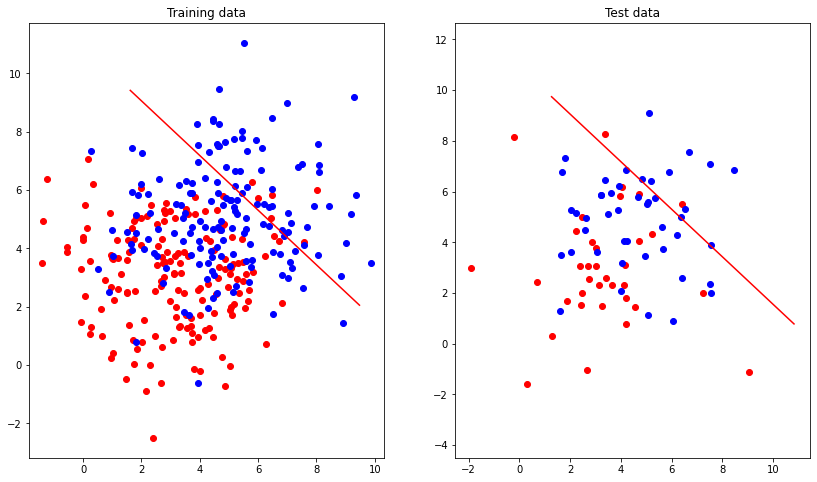

In [10]:
plt.rcParams["figure.figsize"] = (14, 8)
plt.subplot(1, 2, 1)
plot_data(X_train, y_train, 'Training data')
plot_w(X_train, w, b)
plt.subplot(1, 2, 2)
plot_data(X_test, y_test, 'Test data')
plot_w(X_test, w, b)
